In [1]:
! pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [2]:
! pip install keras

In [3]:
! pip install pandas

In [5]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
GPU is available


In [59]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [7]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
import os
import cv2

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
X = []
y = []
IMG_SIZE = 224
DIR = "/content/drive/My Drive/Colab Notebooks/Facial Expressions"
folders1 = os.listdir(DIR)
folders1

['contempt', 'disgust', 'surprise', 'fear', 'sadness', 'anger', 'happy']

In [10]:
for i, file in enumerate(folders1):
    filename = os.path.join(DIR, file)
    print("Folder {} started".format(file))
    try:
        for img in os.listdir(filename):
            path = os.path.join(filename, img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            y.append(i)
    except:
        print("File {} not read".format(path))
        
    print("Folder {} done".format(file))
    print("The folder {} is labeled as {}".format(file, i))



Folder contempt started
Folder contempt done
The folder contempt is labeled as 0
Folder disgust started
Folder disgust done
The folder disgust is labeled as 1
Folder surprise started
Folder surprise done
The folder surprise is labeled as 2
Folder fear started
Folder fear done
The folder fear is labeled as 3
Folder sadness started
Folder sadness done
The folder sadness is labeled as 4
Folder anger started
Folder anger done
The folder anger is labeled as 5
Folder happy started
Folder happy done
The folder happy is labeled as 6


In [11]:
print(len(X))
print(len(y))

981
981


[379, 656, 454, 2, 874, 393, 839, 509, 680, 549, 168, 92, 536, 710, 756, 943]


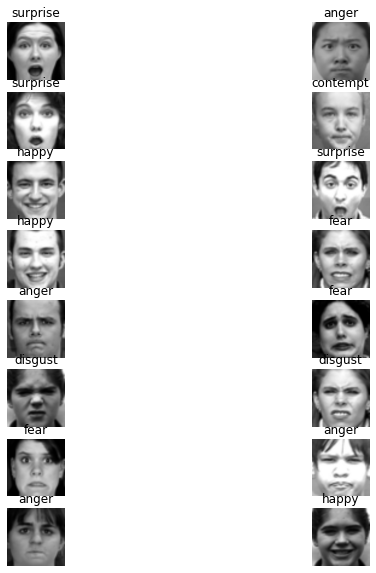

In [16]:
import random
from random import sample
plt.figure(figsize=(10,10))
random_indexes = sample(range(1, 982), 16)
print(random_indexes)
for i, img_index in enumerate(random_indexes):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(8,2, i + 1)
  sp.set_title(folders1[y[img_index]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X[img_index])


In [17]:
X = np.array(X)
y = np.array(y)

print("X shape is {}".format(X.shape))
print("y shape is {}".format(y.shape))

X shape is (981, 224, 224, 3)
y shape is (981,)


In [18]:
from tensorflow.keras.utils import to_categorical

print("Before the categorical the shape of y is {}".format(y.shape))
y = to_categorical(y)
print("After the categorical the shape of y is {}".format(y.shape))

Before the categorical the shape of y is (981,)
After the categorical the shape of y is (981, 7)


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print("There are {} training examples".format(X_train.shape[0]))
print("There are {} test examples".format(X_test.shape[0]))

There are 686 training examples
There are 295 test examples


In [64]:
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      cval=5)


validation_datagen = ImageDataGenerator(
      rescale = 1./255)

In [65]:
training_set=training_datagen.flow(X_train,y_train)
test_set=validation_datagen.flow(X_test,y_test)

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

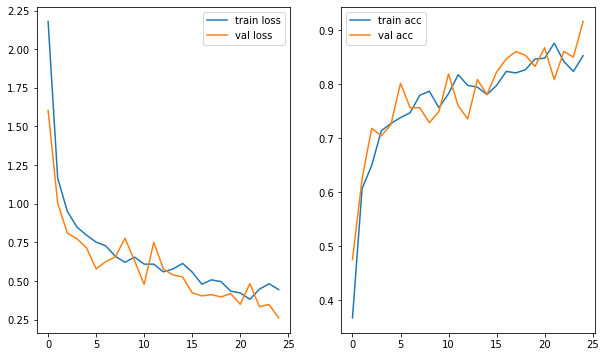

In [66]:

IMAGE_SIZE=[224,224]
vgg= VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

  # don't train existing weights\n",
for layer in vgg.layers:
  layer.trainable = False

folders = glob('/content/drive/My Drive/Colab Notebooks/Facial Expressions/*')
x = Flatten()(vgg.output)
prediction=Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics='accuracy')
batch_size=32
  
r= model.fit_generator(training_set,epochs = 25, validation_data = test_set,verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, validation_steps=X_test.shape[0] // batch_size)

  # plot the loss
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('LossVal_loss')

  # plot the accuracy
plt.subplot(1,2,2)
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('AccVal_acc')

print('The Validation Accuracy of VGG16: ', np.mean(r.history['val_accuracy']))


In [67]:
print('The Validation Accuracy of VGG19: ', np.mean(r.history['val_accuracy']))

The Validation Accuracy of VGG19:  0.7790277755260467


In [68]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('Facial_model_VGG16.h5')

In [69]:
y_pred = model.predict(X_test)
y_pred_digits = np.argmax(y_pred, axis=1)
y_pred_digits

y_pred_labels = np.unique(y_pred_digits, return_counts=True)
y_pred_labels


(array([1, 2, 3, 4, 5, 6]), array([183,  52,  11,   2,   1,  46]))

In [70]:
real_labels= np.argmax(y_test, axis=1)
real_labels
real_labels1 = np.unique(real_labels, return_counts=True)
real_labels1

(array([0, 1, 2, 3, 4, 5, 6]), array([16, 55, 71, 20, 32, 38, 63]))

In [71]:
from sklearn.metrics import confusion_matrix
c_m = confusion_matrix(real_labels, y_pred_digits)
c_m

array([[ 0, 14,  0,  0,  0,  0,  2],
       [ 0, 55,  0,  0,  0,  0,  0],
       [ 0, 17, 52,  1,  0,  0,  1],
       [ 0,  9,  0,  7,  0,  0,  4],
       [ 0, 28,  0,  2,  2,  0,  0],
       [ 0, 37,  0,  0,  0,  1,  0],
       [ 0, 23,  0,  1,  0,  0, 39]])

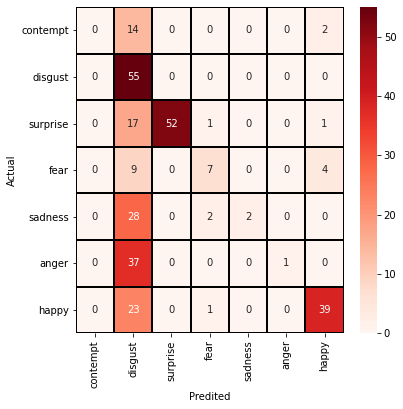

In [72]:

import seaborn as sns
plt.figure(figsize = (6,6))
sns.heatmap(c_m,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = folders1 , yticklabels = folders1)
plt.xlabel('Predited')
plt.ylabel('Actual')
plt.show()

In [73]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score
acc_score = accuracy_score(real_labels, y_pred_digits)
acc_score

0.5288135593220339

In [74]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(real_labels)):
    if(real_labels[i] == y_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==10):
        break
i=0
for i in range(len(real_labels)):
    if(real_labels[i] != y_pred_digits[i]):
        mis_class.append(i)


In [75]:
print(len(prop_class))
print(len(mis_class))

10
139


[1, 2, 7, 0, 4, 9, 3, 6, 8, 5]


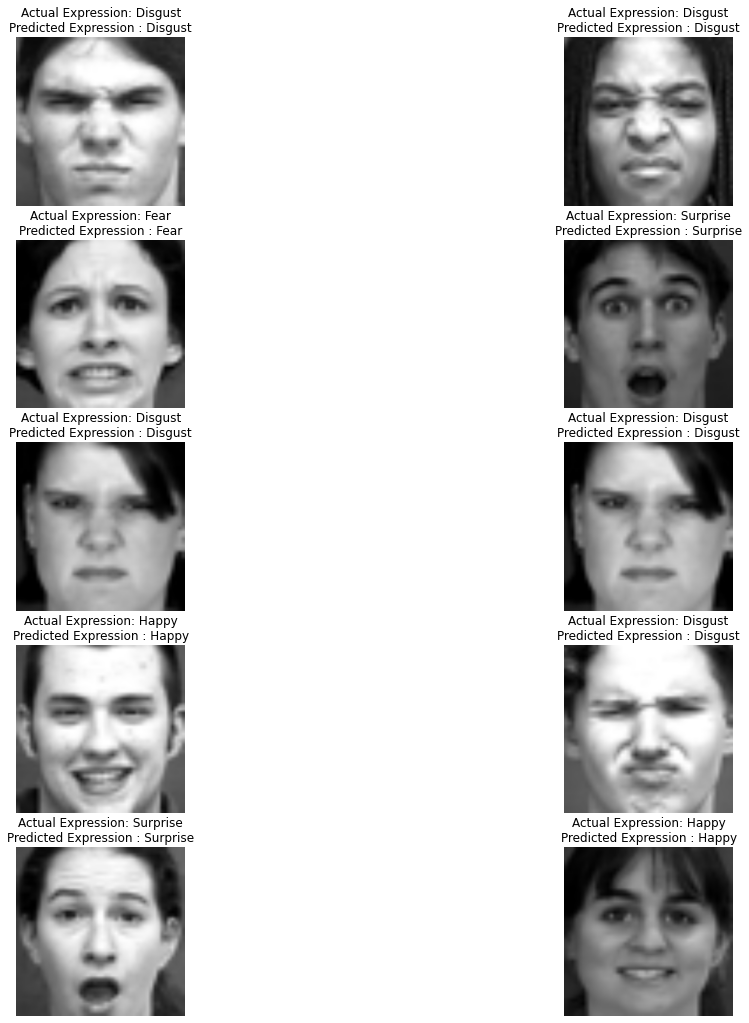

In [78]:
labels_names={0:'Contempt', 
        1:'Disgust',
        2:'Surprise',
        3:'Fear',
        4:'Sadness',
        5:'Anger',
        6:'Happy'
        }
#fig.set_size_inches(8,8)
import random
from random import sample
plt.figure(figsize=(18,18))
random_indexes = sample(range(0, 10), 10)
print(random_indexes)
for i, img_index in enumerate(random_indexes):

  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 2, i + 1)
  sp.set_title('Actual Expression: '+ labels_names[real_labels[prop_class[img_index]]]+ '\n' + 'Predicted Expression : ' + labels_names[y_pred_digits[prop_class[img_index]]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X_test[prop_class[img_index]])

[3, 2, 9, 5, 7, 4, 6, 1, 0, 8]


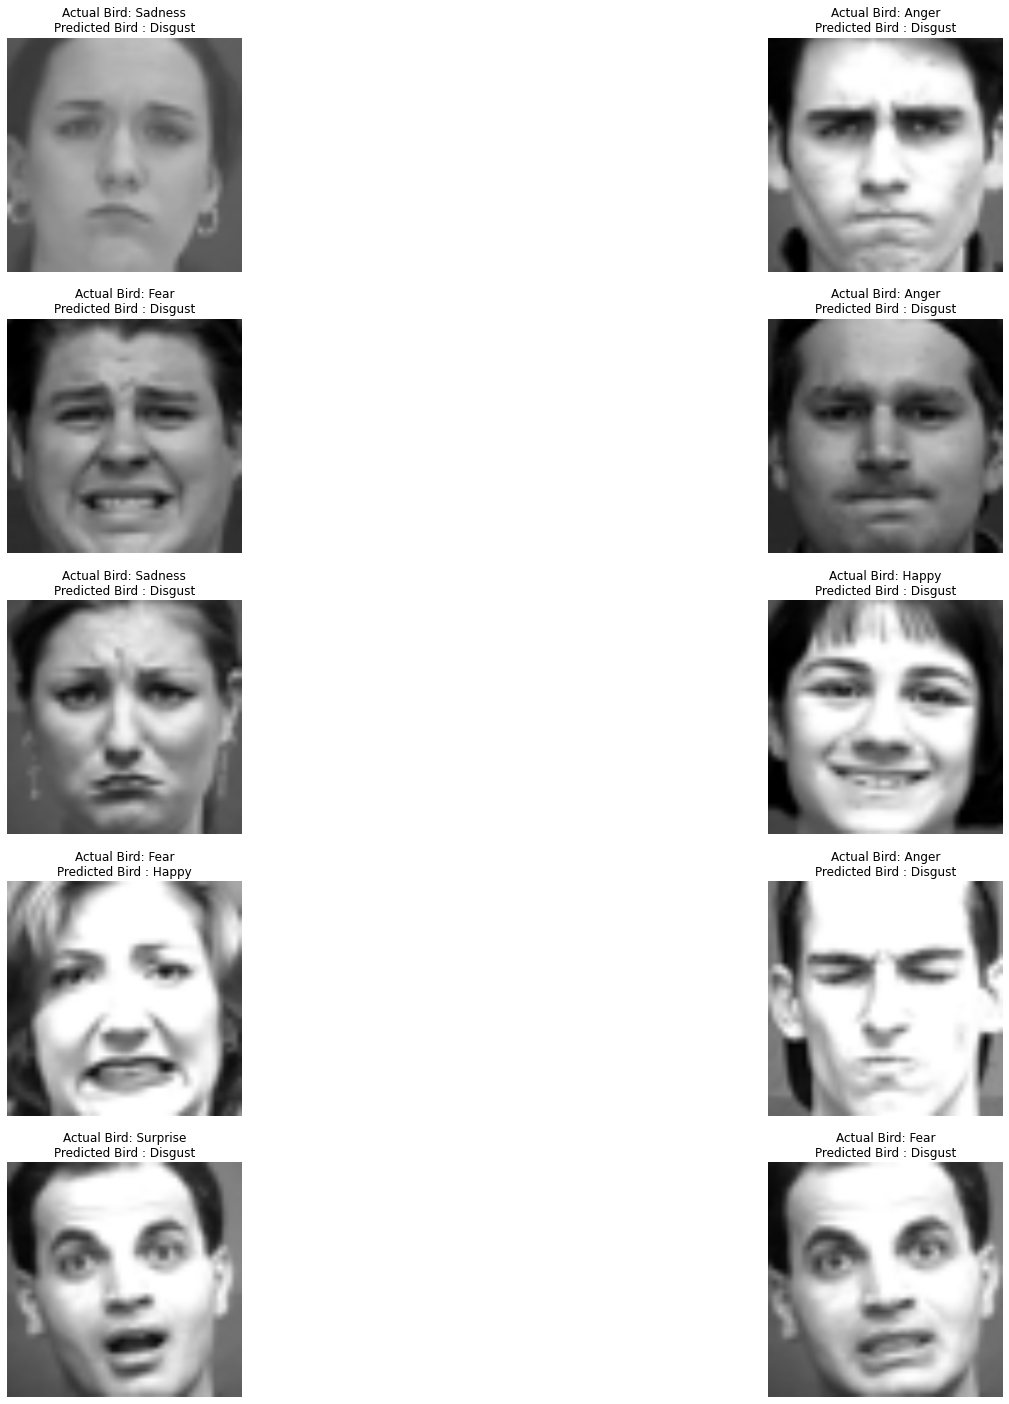

In [79]:
labels_names={0:'Contempt', 
        1:'Disgust',
        2:'Surprise',
        3:'Fear',
        4:'Sadness',
        5:'Anger',
        6:'Happy'
        }
import random
from random import sample

random_indexes = sample(range(0, 10), 10)
print(random_indexes)
plt.figure(figsize=(25,25))
for i, img_index in enumerate(random_indexes):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 2, i + 1)
  sp.set_title('Actual Bird: '+ labels_names[real_labels[mis_class[img_index]]]+ '\n' + 'Predicted Bird : ' + labels_names[y_pred_digits[mis_class[img_index]]])
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(X_test[mis_class[img_index]])

In [ ]:
# Evaluate The Model with Different Images

In [80]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [81]:
model=load_model('Facial_model_VGG16.h5')

In [124]:
img=image.load_img('/content/drive/My Drive/Colab Notebooks/brahman/angry.jpeg',target_size=(224,224))

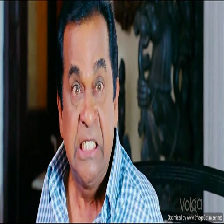

In [125]:
img


In [126]:

y=image.img_to_array(img)
y=np.expand_dims(y,axis=0)
imgy=preprocess_input(y)
imgy=imgy/255

In [127]:
preds= model.predict(imgy)
preds

array([[2.6671992e-06, 2.5253585e-05, 1.2635851e-04, 2.0634648e-01,
        2.3316456e-02, 7.1777534e-01, 5.2407525e-02]], dtype=float32)

In [128]:
a=np.argmax(preds, axis=1)
a

array([5])

In [129]:
if(a==0):
    print("Contempt")
elif(a==1):
    print("Disgust")
elif(a==2):
    print("Surprise")
elif(a==3):
    print("Fear")
elif(a==4):
    print("Sadness")
elif(a==5):
    print("Anger")
else:
  print("Happy")

Anger
